## Imports

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import sparse_categorical_crossentropy

from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D,GlobalAveragePooling2D,BatchNormalization,Dropout
%matplotlib inline
import shutil
import itertools

from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

print ('Library loaded')

Library loaded


In [2]:
inp = '../input/skin-cancer-mnist-ham10000/'
os.listdir(inp)

['hmnist_8_8_RGB.csv',
 'hmnist_28_28_RGB.csv',
 'HAM10000_images_part_1',
 'ham10000_images_part_1',
 'hmnist_8_8_L.csv',
 'HAM10000_images_part_2',
 'ham10000_images_part_2',
 'hmnist_28_28_L.csv',
 'HAM10000_metadata.csv']

### Create the directory structure

In these folders we will store the images that will later be fed to the Keras generators.

In [3]:
folders_to_create = ["HAM10000_224new"]


def create_folders(folders):
    for folder in folders:
        folder_path = os.path.join(folder)
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
            print(f"Folder '{folder}' sudah dibuat.")
        else:
            print(f"Folder '{folder}' sudah ada.")


create_folders(folders_to_create)

Folder 'HAM10000_224new' sudah dibuat.


### Create Train and Val Sets

In [4]:
base = 'HAM10000_224new'

data_pd = pd.read_csv(inp+'HAM10000_metadata.csv')
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [5]:
train_dir = os.path.join(base, "train_dir")
test_dir = os.path.join(base, "test_dir")

In [6]:
df_count = data_pd.groupby('lesion_id').count()
df_count.head()

,image_id,dx,dx_type,age,sex,localization
lesion_id,,,,,,
HAM_0000000,2,2,2,2,2,2
HAM_0000001,1,1,1,1,1,1
HAM_0000002,3,3,3,3,3,3
HAM_0000003,1,1,1,1,1,1
HAM_0000004,1,1,1,1,1,1


In [7]:
df_count = df_count[df_count['dx'] == 1]
df_count.reset_index(inplace=True)

In [8]:
#Memeriksa apakah terdapat gambar yang memiliki duplikat
def duplicates(x):
    unique = set(df_count['lesion_id'])
    if x in unique:
        return 'no'
    else:
        return 'duplicates'

data_pd['is_duplicate'] = data_pd['lesion_id'].apply(duplicates)
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,duplicates


In [9]:
df_count = data_pd[data_pd['is_duplicate'] == 'no']

data_pd['is_duplicate'].value_counts()

no            5514
duplicates    4501
Name: is_duplicate, dtype: int64

In [10]:
#Melihat gambar-gambar yang terduplikat
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

data_pd.dx=data_pd.dx.astype('category',copy=True)
data_pd['label']=data_pd.dx.cat.codes # Convert the labels to numbers
data_pd['lesion_type']= data_pd.dx.map(lesion_type_dict)
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate,label,lesion_type
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,duplicates,2,Benign keratosis
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,duplicates,2,Benign keratosis
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,duplicates,2,Benign keratosis
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,duplicates,2,Benign keratosis
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,duplicates,2,Benign keratosis


In [11]:
#Total gambar perkelas
class_counts = data_pd['lesion_type'].value_counts()
print(class_counts)

Melanocytic nevi        6705
Melanoma                1113
Benign keratosis        1099
Basal cell carcinoma     514
Actinic keratoses        327
Vascular lesions         142
Dermatofibroma           115
Name: lesion_type, dtype: int64


In [12]:
# #Split test data 20%
train, test_df = train_test_split(df_count, test_size=0.20, stratify=df_count['dx'])

#Split test data 20%
#train, test_df = train_test_split(data_pd, test_size=0.20, stratify=data_pd['dx'])

In [13]:
#Memeriksa tiap gambar masuk kedalam jenis train atau test
def identify_trainOrtest(x):
    test_data = set(test_df['image_id'])
    if str(x) in test_data:
        return 'test'
    else:
        return 'train'

#membuat train_df
data_pd['train_test_split'] = data_pd['image_id'].apply(identify_trainOrtest)
train_df = data_pd[data_pd['train_test_split'] == 'train']
train_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate,label,lesion_type,train_test_split
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,duplicates,2,Benign keratosis,train
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,duplicates,2,Benign keratosis,train
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,duplicates,2,Benign keratosis,train
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,duplicates,2,Benign keratosis,train
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,duplicates,2,Benign keratosis,train


In [14]:
test_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate
5617,HAM_0002727,ISIC_0025459,nv,follow_up,50.0,female,back,no
3505,HAM_0004080,ISIC_0028613,nv,follow_up,35.0,male,lower extremity,no
3598,HAM_0004834,ISIC_0025328,nv,follow_up,20.0,female,trunk,no
8702,HAM_0000485,ISIC_0024959,nv,histo,45.0,male,chest,no
7973,HAM_0004583,ISIC_0034200,nv,consensus,55.0,male,unknown,no


In [15]:
#membagi kelas
train_list = list(train_df['image_id'])
test_list = list(test_df['image_id'])

#Total data untuk train dan test
print(len(train_list))
print(len(test_list))

8912
1103


In [16]:
data_pd.set_index('image_id', inplace=True)

In [17]:
#membuat berkas train
os.mkdir(train_dir)
os.mkdir(test_dir)

In [18]:
classname = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
for i in classname:
  directory1=train_dir+'/'+i
  directory2=test_dir+'/'+i
  os.mkdir(directory1)
  os.mkdir(directory2)

folder_1 = os.listdir(inp+'ham10000_images_part_1')
folder_2 = os.listdir(inp+'ham10000_images_part_2')

# memasukkan gambar ke train set
for image in train_list:
    fname = image + '.jpg'
    label = data_pd.loc[image, 'dx']

    if fname in folder_1:
        src = os.path.join(inp+'ham10000_images_part_1', fname)
        dst = os.path.join(train_dir, label, fname)
        
        shutil.copyfile(src, dst)

    if fname in folder_2:
        src = os.path.join(inp+'ham10000_images_part_2', fname)
        dst = os.path.join(train_dir, label, fname)
        
        shutil.copyfile(src, dst)

#  memasukkan gambar ke test set
for image in test_list:
    fname = image + '.jpg'
    label = data_pd.loc[image, 'dx']

    if fname in folder_1:
        src = os.path.join(inp+'ham10000_images_part_1', fname)
        dst = os.path.join(test_dir, label, fname)
        
        shutil.copyfile(src, dst)

    if fname in folder_2:
        src = os.path.join(inp+'ham10000_images_part_2', fname)
        dst = os.path.join(test_dir, label, fname)
        
        shutil.copyfile(src, dst)

# menghitung total gambar tiap kelas train set
train_class_counts = train_df['lesion_type'].value_counts()
print("Train File Class Counts:")
print(train_class_counts)

Train File Class Counts:
Melanocytic nevi        5822
Melanoma                1067
Benign keratosis        1011
Basal cell carcinoma     479
Actinic keratoses        297
Vascular lesions         129
Dermatofibroma           107
Name: lesion_type, dtype: int64


In [19]:
#augmentasi gambar
classname = ["akiec", "bcc", "bkl", "df", "mel", "nv", "vasc"]
for img_class in classname:
    aug_dir = os.path.join(base, "aug_dir")
    os.mkdir(aug_dir)
    img_dir = os.path.join(aug_dir, "img_dir")
    os.mkdir(img_dir)

    img_list = os.listdir(
        os.path.join(base, "train_dir", img_class)
    )
    for file_name in img_list:
        source = os.path.join(
            base, "train_dir", img_class, file_name
        )
        target = os.path.join(img_dir, file_name)
        shutil.copyfile(source, target)

    source_path = aug_dir
    save_path = os.path.join(base, "train_dir", img_class)
    batch_size = 50

    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.05,
    )

    aug_datagen = datagen.flow_from_directory(
        source_path,
        save_to_dir=save_path,
        save_format="jpg",
        target_size=(224, 224),
        batch_size=batch_size,
    )
    aug_images = 6000

    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((aug_images - num_files) / batch_size))

    for i in range(0, num_batches):
        images, labels = next(aug_datagen)

    # hapus temporary directory
    shutil.rmtree(aug_dir)

Found 297 images belonging to 1 classes.
Found 479 images belonging to 1 classes.
Found 1011 images belonging to 1 classes.
Found 107 images belonging to 1 classes.
Found 1067 images belonging to 1 classes.
Found 5822 images belonging to 1 classes.
Found 129 images belonging to 1 classes.


In [20]:
#menghitung total kelas setelah augmentasi pada train set
def count_images_per_class(directory):
    class_counts = {}

    for img_class in os.listdir(directory):
        class_path = os.path.join(directory, img_class)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[img_class] = num_images

    return class_counts


augmented_train_dir = os.path.join(base, "train_dir")

augmented_class_counts = count_images_per_class(augmented_train_dir)

print("Banyak gambar per kelas pada train_df setelah augmentasi:")
for img_class, count in augmented_class_counts.items():
    print(f"{img_class}: {count} images")

Banyak gambar per kelas pada train_df setelah augmentasi:
nv: 6022 images
df: 4330 images
bcc: 5798 images
akiec: 5990 images
mel: 5885 images
bkl: 5855 images
vasc: 5210 images


In [21]:
# melihat banyaknya total gambar tiap kelas
test_class_counts = test_df["dx"].value_counts()
print("Banyak gambar per kelas pada test_df:")
print(test_class_counts)

Banyak gambar per kelas pada test_df:
nv       883
bkl       88
mel       46
bcc       35
akiec     30
vasc      13
df         8
Name: dx, dtype: int64


### Training Model

In [166]:
train_path = '/kaggle/working/HAM10000_224new/train_dir'
test_path = '/kaggle/working/HAM10000_224new/test_dir'

batch_size = 32

image_size = 224

In [167]:
# #VGG16
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=True)

test_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=False)

Found 39090 images belonging to 7 classes.
Found 1103 images belonging to 7 classes.


In [182]:
base_model = tf.keras.applications.VGG16(
    include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3)
)

for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-4:]:
    layer.trainable = True

In [183]:
# #VGG16
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1024, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(7, activation="softmax"))

model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_12  (None, 512)               0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_24 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 1024)              525312    
_________________________________________________________________
batch_normalization_35 (Batc (None, 1024)              4096      
_________________________________________________________________
dropout_25 (Dropout)         (None, 1024)            

In [185]:
model.compile(
    optimizer="Adam",
    loss="categorical_crossentropy",
    metrics=["acc"],
)

In [186]:
#VGG16
checkpoint = ModelCheckpoint(
    filepath="VGG16fix.hdf5",
    monitor="val_acc",
    save_best_only=True,
    verbose=1,
    mode="max",
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_acc",
    factor=0.5,
    patience=2,
    verbose=1,
    mode="max",
    min_lr=0.00001,
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
)

In [187]:
history = model.fit(
    train_batches,
    steps_per_epoch=(len(train_df) // batch_size),
    epochs=40,
    verbose=1,
    validation_data=test_batches,
    validation_steps=(len(test_df) // batch_size),
    callbacks=[checkpoint, reduce_lr, early_stopping],
)

Epoch 1/40
278/278 [==============================] - 51s 180ms/step - loss: 1.4768 - acc: 0.5306 - val_loss: 1.1856 - val_acc: 0.8327

Epoch 00001: val_acc improved from -inf to 0.83272, saving model to VGG16fix.hdf5
Epoch 2/40
278/278 [==============================] - 50s 179ms/step - loss: 0.9906 - acc: 0.6622 - val_loss: 1.1426 - val_acc: 0.7895

Epoch 00002: val_acc did not improve from 0.83272
Epoch 3/40
278/278 [==============================] - 50s 178ms/step - loss: 0.7582 - acc: 0.7282 - val_loss: 0.5136 - val_acc: 0.8548

Epoch 00003: val_acc improved from 0.83272 to 0.85478, saving model to VGG16fix.hdf5
Epoch 4/40
278/278 [==============================] - 48s 173ms/step - loss: 0.6665 - acc: 0.7612 - val_loss: 0.4898 - val_acc: 0.8300

Epoch 00004: val_acc did not improve from 0.85478
Epoch 5/40
278/278 [==============================] - 50s 179ms/step - loss: 0.5955 - acc: 0.7793 - val_loss: 25.8922 - val_acc: 0.0450

Epoch 00005: val_acc did not improve from 0.85478

E

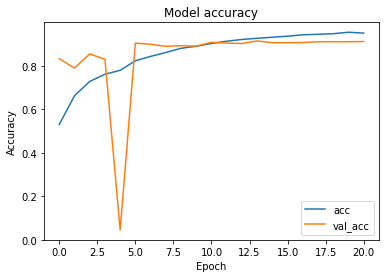

In [188]:
# plot grafik akurasi
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["acc", "val_acc"], loc="lower right")
plt.show()

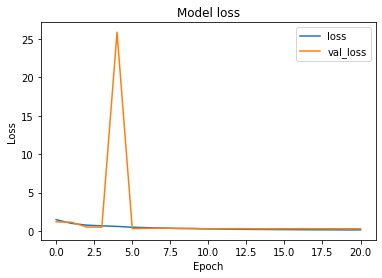

In [189]:
# plot grafik loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss", "val_loss"], loc="upper right")
plt.show()

In [190]:
# model.save("VGG16.hdf5")
model.save("VGG16fix.hdf5")

In [191]:
train_score = model.evaluate(train_batches, verbose=1)
test_score = model.evaluate(test_batches, verbose=1)

print("Train loss: ", train_score[0])
print("Train acc: ", train_score[1])
print("-" * 75)
print("Test loss: ", test_score[0])
print("Test acc: ", test_score[1])

35/35 [==============================] - 12s 346ms/step - loss: 0.2841 - acc: 0.9075
Train loss:  0.18196049332618713
Train acc:  0.9369403719902039
---------------------------------------------------------------------------
Test loss:  0.2840670347213745
Test acc:  0.9075249433517456


In [192]:
y_true = np.array([])
for i in range(len(test_batches)):
    batch = next(test_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(test_batches.class_indices.keys())
print(classname_label)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


34/34 [==============================] - 12s 340ms/step

Classification Report:
               precision    recall  f1-score   support

       akiec    0.58333   0.46667   0.51852        30
         bcc    0.79412   0.77143   0.78261        35
         bkl    0.76623   0.67045   0.71515        88
          df    0.80000   0.50000   0.61538         8
         mel    0.57143   0.43478   0.49383        46
          nv    0.94645   0.98075   0.96329       883
        vasc    0.84615   0.84615   0.84615        13

    accuracy                        0.90752      1103
   macro avg    0.75825   0.66718   0.70499      1103
weighted avg    0.89948   0.90752   0.90218      1103



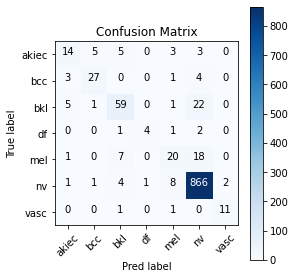

In [193]:
true_labels = test_batches.classes
model.load_weights("VGG16fix.hdf5")

#model.load_weights("VGG16.hdf5")
predictions = model.predict(test_batches, steps=len(test_df) / batch_size, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
class_report = classification_report(
    true_labels, predicted_labels, target_names=train_batches.class_indices, digits=5
)
print("\nClassification Report:\n", class_report)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(4, 4))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(
        j,
        i,
        conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

In [194]:
y_true = np.array([])
for i in range(len(train_batches)):
    batch = next(train_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(train_batches.class_indices.keys())
print(classname_label)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


Found 39090 images belonging to 7 classes.
1222/1222 [==============================] - 152s 124ms/step

Training Classification Report:
               precision    recall  f1-score   support

       akiec    0.95425   0.96795   0.96105      5990
         bcc    0.95992   0.97896   0.96935      5798
         bkl    0.86255   0.87566   0.86906      5855
          df    0.99448   0.99792   0.99620      4330
         mel    0.89521   0.82600   0.85921      5885
          nv    0.91325   0.93524   0.92411      6022
        vasc    0.99904   1.00000   0.99952      5210

    accuracy                        0.93694     39090
   macro avg    0.93981   0.94025   0.93978     39090
weighted avg    0.93658   0.93694   0.93650     39090



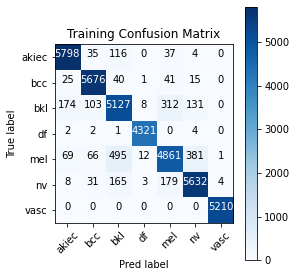

In [195]:
train_all_batches = datagen.flow_from_directory(
    directory=train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)

num_train_steps = len(train_all_batches)

train_predictions = model.predict(train_all_batches, steps=num_train_steps, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_all_batches.classes

train_class_report = classification_report(
    train_true_labels,
    train_predicted_labels,
    target_names=train_all_batches.class_indices,
    digits=5,
)
print("\nTraining Classification Report:\n", train_class_report)

train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(4, 4))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()